",#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng,Funding\n0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369,1700.0\n1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.9885,733.0\n2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857,116.0\n3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369,500.0\n4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942,15000.0\n5,16,Bolt,San Francisco Bay Area,USA,North America,130,2023-12-14,29.0,450,320,Finance,Series E,$1300,2023,37.77493,-122.41942,1300.0\n6,20,Invitae,San Francisco Bay Area,USA,No

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata


## Loading in data

Plots to generate:
 - Correlation between funding and either % layoffs or number layoffs - Kirkland
 - Distribution of company size (given by in stage and funding) - Matthew
 - Correlation between employee count and layoff size (% or raw number) - Ana
 - Industry-based layoffs - Mckayla
 - Regional based layoffs (are different countries laying off more?) - Sebastian

In [136]:
df = pd.read_excel('/Users/sebastian/Documents/code-things/Group019_WI24/data/tech_layoffs.xlsx')
df.head()

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942


## Correcting data types

In order to prepare the data for exploratory analysis, we are going to correct the datatypes such that they are easily usable by plotting functions.

In [137]:
df.dtypes

#                                       int64
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                                int64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs             int64
Company_Size_after_layoffs              int64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                  object
Year                                    int64
lat                                   float64
lng                                   float64
dtype: object

In [138]:
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Funding'].head()

0     1700.0
1      733.0
2      116.0
3      500.0
4    15000.0
Name: Funding, dtype: float64

#### Geographic Regions
Our data comes with latitude and longitude values, so let's look into some geographic analysis. With a geographic plot we can see _where_ our data is coming from. This will give us insight into any bias introduced to our data, since we can only analyze the countries we have data from. Additionally, it can give some insight into which countries lay off a higher percentage of their employees.

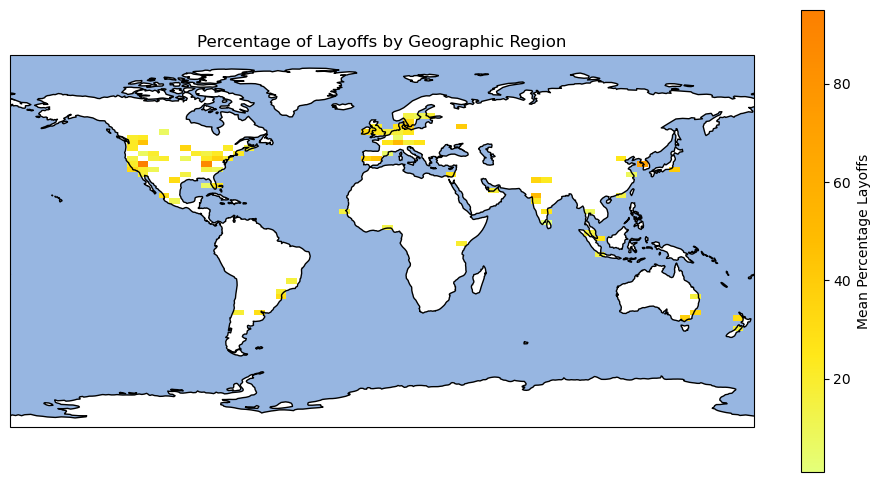

In [139]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()

num_bins = 70
lat_bins = np.linspace(-90, 90, num_bins + 1)
lng_bins = np.linspace(-180, 180, num_bins + 1)

lat_indices = np.digitize(df['lat'], lat_bins) - 1 
lng_indices = np.digitize(df['lng'], lng_bins) - 1

percentage_means = np.zeros((num_bins, num_bins))

for i in range(num_bins):
    for j in range(num_bins):
        in_bin = (lat_indices == i) & (lng_indices == j)
        if np.any(in_bin):
            percentage_means[i, j] = df['Percentage'][in_bin].mean()

percentage_means_masked = np.ma.masked_where(percentage_means == 0, percentage_means)

pcm = ax.pcolormesh(lng_bins, lat_bins, percentage_means_masked, cmap='Wistia', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
plt.colorbar(pcm, ax=ax, label='Mean Percentage Layoffs')
plt.title('Percentage of Layoffs by Geographic Region')
plt.show()

From our plot, we can see that we have very little data from Russia, Africa, and South America. From this plot we are not able to determine the amount of data in each box, however we can see that the US appears to have the harshest layoffs. Let's look into that a little more to determine if that's true. 

<Figure size 1600x600 with 0 Axes>

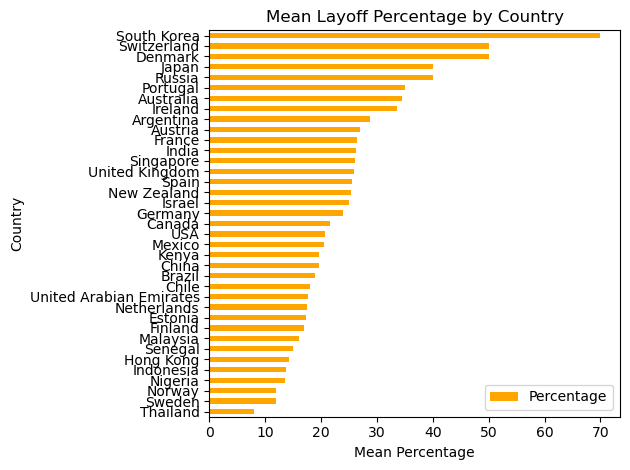

In [140]:
by_country = df[['Country', 'Percentage']].groupby('Country').mean().sort_values(by='Percentage', ascending=True)
plt.figure(figsize=(16, 6))
by_country.plot(kind='barh', color='orange')

plt.xlabel('Mean Percentage')
plt.title('Mean Layoff Percentage by Country')
plt.tight_layout()
plt.show()

This plot is telling us South Korea is astoundingly harsher with their layoffs, however we believe it could be an artifact of the data. Let's remake the plot, but exclude countries that have less than 3 observations, to avoid outliers like this.

<Figure size 1600x600 with 0 Axes>

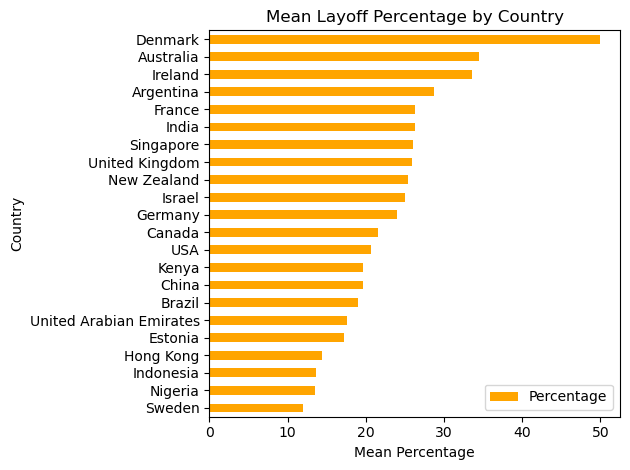

In [141]:
country_counts = df['Country'].value_counts()
three_observations = df[df['Country'].apply(lambda country: country_counts[country] >= 3)]
by_country = three_observations[['Country', 'Percentage']].groupby('Country').mean().sort_values(by='Percentage', ascending=True)
plt.figure(figsize=(16, 6))
by_country.plot(kind='barh', color='orange')

plt.xlabel('Mean Percentage')
plt.title('Mean Layoff Percentage by Country')
plt.tight_layout()
plt.show()

This is a lot different, and shows that our geographic plot may be misleading, as it is hard to determine the spread of the data by country when there are many different boxes for one country (like USA). We can see here that in the given data, Denmark performs the harshest layoffs, with a mean around 50%. All of our geographic analysis has been by percentage, let's look into these plots but for the amount of employees laid off. This will enable larger companies to dominate the plots, as they have more employees to layoff. Since this data is now numeric and not forced to be within the range of 0-100, like percentage, we can simply sum the amount of layoffs for each bin or bar plot.

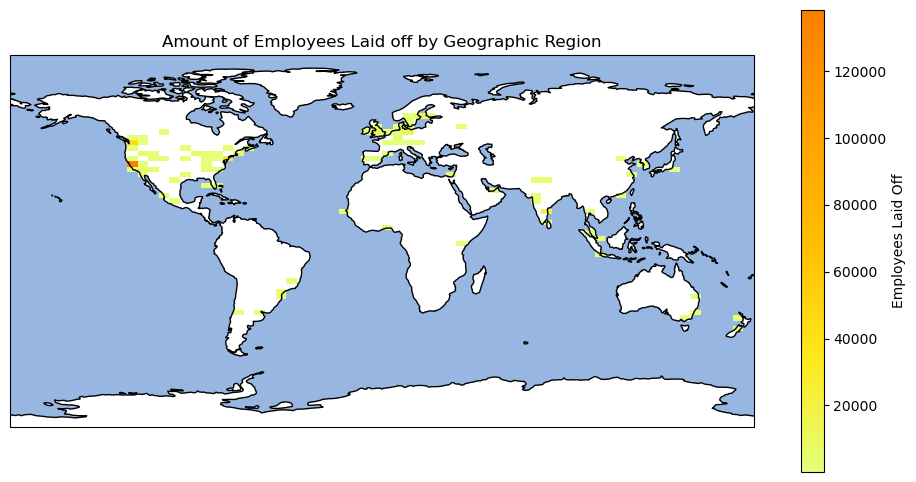

In [142]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()

num_bins = 70
lat_bins = np.linspace(-90, 90, num_bins + 1)
lng_bins = np.linspace(-180, 180, num_bins + 1)

lat_indices = np.digitize(df['lat'], lat_bins) - 1 
lng_indices = np.digitize(df['lng'], lng_bins) - 1

percentage_means = np.zeros((num_bins, num_bins))

for i in range(num_bins):
    for j in range(num_bins):
        in_bin = (lat_indices == i) & (lng_indices == j)
        if np.any(in_bin):
            percentage_means[i, j] = df['Laid_Off'][in_bin].sum()

percentage_means_masked = np.ma.masked_where(percentage_means == 0, percentage_means)

pcm = ax.pcolormesh(lng_bins, lat_bins, percentage_means_masked, cmap='Wistia', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
plt.colorbar(pcm, ax=ax, label='Employees Laid Off')
plt.title('Amount of Employees Laid off by Geographic Region')
plt.show()

This plot is quite different, and shows a super high amount of layoffs in the silicon valley region of California. This suggests that our data is highly packed with tech-related layoffs, and could cause a certain amount of bias when building a model. Let's look into that a little more.

In [143]:
df['Location_HQ'].value_counts()

Location_HQ
San Francisco Bay Area    388
New York City             160
Bengaluru                  64
Boston                     60
Los Angeles                51
                         ... 
Kfar Saba                   1
Noida                       1
Frankfurt                   1
Bangkok                     1
Lisbon                      1
Name: count, Length: 132, dtype: int64

Looking at this, it is pretty clear that data from the Bay Area is the most occurent in our dataset. Let's perform a bootstrap test to see if there are significant differences in our data that are not caused by sampling. A bootstrap is a process where we resample the data to see if the observed difference in our target variable, mean percentage of employees laid off, is observed due to chance, or observed due to a true difference in our data. Bootstrapping is effective at determining if the bay area is biasing our data since it does not require the data to have a specific distribution. This allows us to perform an analysis and understand the impact of this potential bias. This bootstrap will be a two-tailed test, which means we are looking to analyze if there is any difference between the two groups. The reason we are doing this instead of looking for difference in a specific direction is because we are looking for bias in general, and it does not matter if the bias is influencing the mean to be lower or higher. Our alpha value for this p-test will be 0.05. This was chosen as it is a commonly accepted p-value, and we are willing to be more generous with the possible identification of bias, as opposed to using a p-value such as 0.01.

In [144]:
bay = df.copy()
bay['bay'] = df['Location_HQ'].apply(lambda hq: hq == 'San Francisco Bay Area')
in_bay = bay[bay['bay']]
out_bay = bay[bay['bay'] == False]

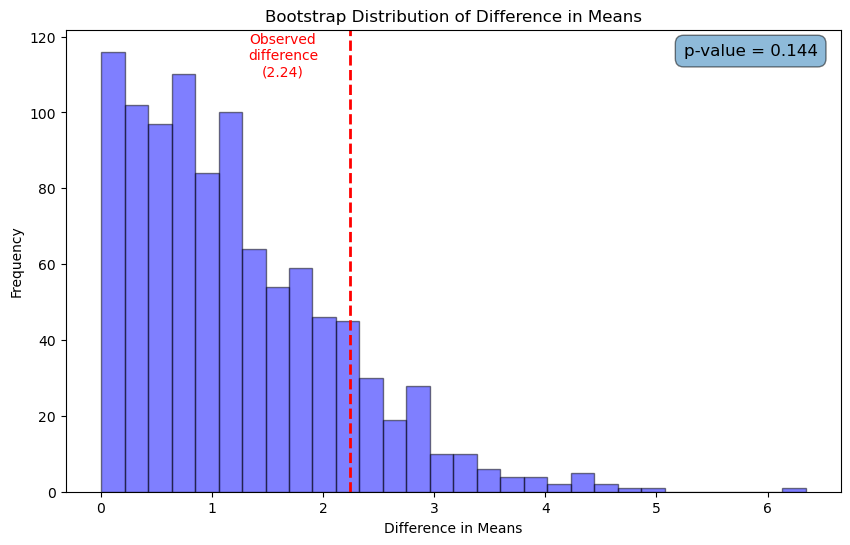

In [203]:
from scipy.stats import ttest_ind
from sklearn.utils import resample

inside_bay = bay[bay['bay'] == True]['Percentage']
outside_bay = bay[bay['bay'] == False]['Percentage']
observed_diff = np.abs(inside_bay.mean() - outside_bay.mean())

n_iterations = 1000
n_size = int(len(bay) * 0.50)
diff_means = np.zeros(n_iterations)

for i in range(n_iterations):
    sample = resample(bay['Percentage'], n_samples=n_size)
    inside_bay_sample = sample[:int(n_size / 2)]
    outside_bay_sample = sample[int(n_size / 2):]
    diff_means[i] = np.abs(inside_bay_sample.mean() - outside_bay_sample.mean())

p_value = np.sum(diff_means >= observed_diff) / n_iterations

plt.figure(figsize=(10, 6))
plt.hist(diff_means, bins=30, alpha=0.5, color='blue', edgecolor='black')

plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2)

plt.text(observed_diff - 0.6, plt.ylim()[1] * 0.9, f'Observed\ndifference\n({observed_diff:.2f})',
         horizontalalignment='center', color='red')
plt.text(0.97, 0.97, f'p-value = {p_value:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.5", alpha=0.5))
plt.title('Bootstrap Distribution of Difference in Means')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.show()

With a p-value of 0.144, we are able to conclude that there is not sufficient evidence for difference in percetange of employees laid off given the company being based in the bay area or not. This suggests that our data containing a large majority of observations from one location is not a bias when it comes to observing the percentage of employees laid off.

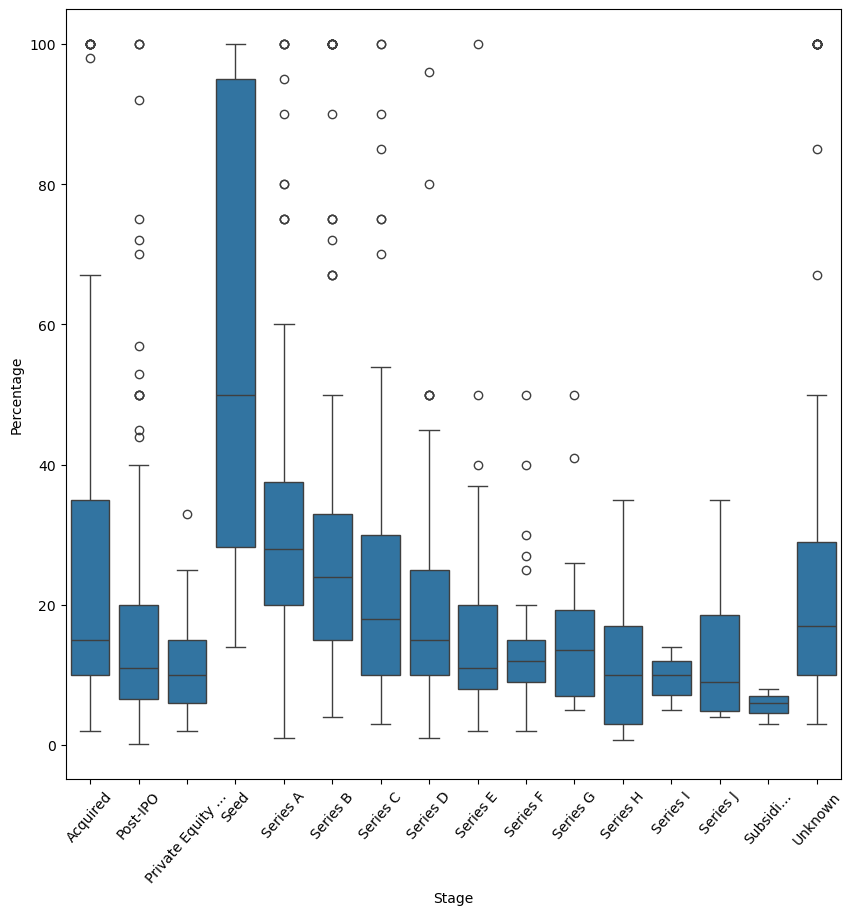

In [197]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Stage', y='Percentage', data=df.sort_values(by='Stage'))
plt.xticks(rotation=49)
plt.show()

In [187]:
import patsy
from collections import defaultdict
import statsmodels.api as sm

The `Stage` column of the data can be treated partially as ordinal data. This is because they have funding stages A-J, which represent how many rounds of funding the company has gone through. We can convert this into an integer based column, such that we can perform regression on it. Additionally, we can include the value `seed`, as it represents the company with 0 rounds of funding. Once they are converted, we will use linear regression to determine if the funding stage correlates with the percentage of employees laid off. This will help us conclude if `Series` is correlated, and therefore able to predict, if a company is more likely to perform layoffs. 

In [188]:
series = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
stage_numerizer = dict(zip([f'Series {s}' for s in series], np.arange(1, len(series)+1, 1)))
stage_numerizer['Seed'] = 0
numerizer = defaultdict(lambda : np.nan)
numerizer.update(stage_numerizer)
clear_funding = df[['Percentage', 'Funding', 'Stage']]
clear_funding['Stage_numerized'] = clear_funding['Stage'].apply(lambda i: numerizer[i])

/var/folders/mt/kt4lp3rx2p37sfswrnyhlkjr0000gn/T/ipykernel_11336/4198447878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_funding['Stage_numerized'] = clear_funding['Stage'].apply(lambda i: numerizer[i])


In [189]:
outcome, predictors = patsy.dmatrices('Percentage ~ Stage_numerized', clear_funding)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Percentage   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     134.2
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           7.21e-29
Time:                        12:19:00   Log-Likelihood:                -3603.9
No. Observations:                 828   AIC:                             7212.
Df Residuals:                     826   BIC:                             7221.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          37.2293      1.341     

With a measured p-value of 0.000, this means we are able to disprove the null hypothesis, resulting in the conclusion that there is a statistically significant correlation between the funding stage of a company and the percentage of employees laid off. With a negative correlation coefficient, it also results in the conclsuion that a company that has had more funding rounds is less likely to layoff a higher percentage of their employees. This is likely due to the fact that as you recieve more funding, your employee count rises. This means that a similarly sized layoff, when compared to a smaller company, will actually have a lower percentage. It also allows us to conclude that your job is more safe at a larger company, since they are less likely to layoff a large portion of their employees. 

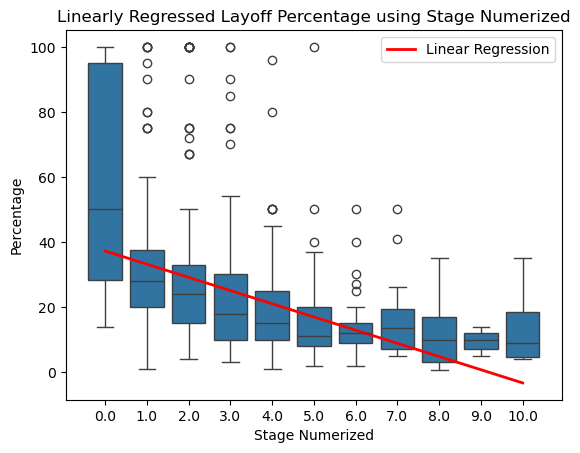

In [209]:
sns.boxplot(x='Stage_numerized', y='Percentage', data=clear_funding)
stages = np.sort(clear_funding['Stage_numerized'].unique())

predicted_percentage = 37.2293 - 4.0583 * stages

sns.lineplot(x=stages, y=predicted_percentage, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Stage Numerized')
plt.legend(loc='upper right')
plt.title('Linearly Regressed Layoff Percentage using Stage Numerized')
plt.show()